# Scraping UIUC CS faculty homepages

## System setup 

Before we start, make sure to install the required libraries
    
    pip install bs4
    pip install selenium

Since UIUC's website has some javascript rendered HTML content, we'll be using Selenium for scraping the content loaded dynamically by javascript. For this,you would also need to download a selenium supported browser webdriver.

e.g. For Chrome, download the appropriate webdriver from here: http://chromedriver.chromium.org/downloads, unzip it and save in current directory.

In [22]:
pip install selenium

Note: you may need to restart the kernel to use updated packages.


In [23]:
from bs4 import BeautifulSoup
from selenium import webdriver 
from selenium.webdriver.chrome.options import Options
import re 
import urllib
import time

In [24]:
#create a webdriver object and set options for headless browsing
options = Options()
options.headless = True
driver = webdriver.Chrome('./chromedriver',options=options)

If you visit UIUC's CS Faculty Directory Listing: https://cs.illinois.edu/about/people/all-faculty , you'll notice that it has all the faculty listed there. 
Clicking on a faculty's name takes you to the Faculty Profile page. 
The profile page has more info about the faculty and sometimes contains the faculty hompage url under the "For More Information" header which is what we want to scrape.

Before we start scraping, we'll define some helper functions

In [25]:
#uses webdriver object to execute javascript code and get dynamically loaded webcontent
def get_js_soup(url,driver):
    driver.get(url)
    res_html = driver.execute_script('return document.body.innerHTML')
    soup = BeautifulSoup(res_html,'html.parser') #beautiful soup object to be used for parsing html content
    return soup

#tidies extracted text 
def process_bio(bio):
    bio = bio.encode('ascii',errors='ignore').decode('utf-8')       #removes non-ascii characters
    bio = re.sub('\s+',' ',bio)       #repalces repeated whitespace characters with single space
    return bio

''' More tidying
Sometimes the text extracted HTML webpage may contain javascript code and some style elements. 
This function removes script and style tags from HTML so that extracted text does not contain them.
'''
def remove_script(soup):
    for script in soup(["script", "style"]):
        script.decompose()
    return soup


#Checks if bio_url is a valid faculty homepage
def is_valid_homepage(bio_url,dir_url):
    if bio_url.endswith('.pdf'): #we're not parsing pdfs
        return False
    try:
        #sometimes the homepage url points to the same page as the faculty profile page
        #which should be treated differently from an actual homepage
        ret_url = urllib.request.urlopen(bio_url).geturl() 
    except:
        return False       #unable to access bio_url
    urls = [re.sub('((https?://)|(www.))','',url) for url in [ret_url,dir_url]] #removes url scheme (https,http or www) 
    return not(urls[0]== urls[1])

We will now start scraping.

First, let's get links to all Faculty Profile pages by scraping the Directory Listing. You can use your browser's developer tools to find the required links within the HTML content. In Chrome, this can be done by right cliking on the webpage and choosing Inspect. Some basic knowledge of HTML and CSS would be required. After a bit of digging, you should notice that the link can be found under the <a\> tag of <div\> with the class "name" as shown:

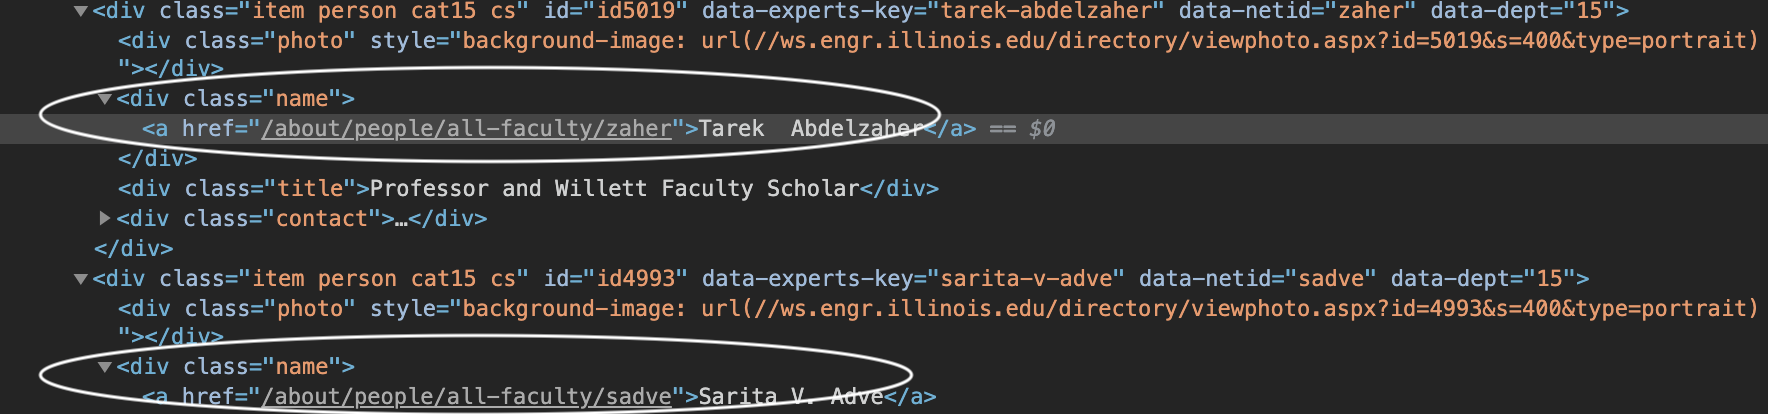


Now we can specify exactly what needs to be extracted from the directory listing page

In [26]:
#extracts all Faculty Profile page urls from the Directory Listing Page
def scrape_dir_page(dir_url,driver):
    print ('-'*20,'Scraping directory page','-'*20)
    faculty_links = []
    faculty_base_url = 'https://cs.illinois.edu'
    #execute js on webpage to load faculty listings on webpage and get ready to parse the loaded HTML 
    soup = get_js_soup(dir_url,driver)     
    for link_holder in soup.find_all('div',class_='name'): #get list of all <div> of class 'name'
        rel_link = link_holder.find('a')['href'] #get url
        #url returned is relative, so we need to add base url
        faculty_links.append(faculty_base_url+rel_link) 
    print ('-'*20,'Found {} faculty profile urls'.format(len(faculty_links)),'-'*20)
    return faculty_links

It might take a few minutes to get all the urls

In [27]:
dir_url = 'https://cs.illinois.edu/about/people/all-faculty' #url of directory listings of CS faculty
faculty_links = scrape_dir_page(dir_url,driver)

-------------------- Scraping directory page --------------------
-------------------- Found 192 faculty profile urls --------------------


Now let's scrape the faculty profile pages. 

The faculty homepages are listed under the "For more information" header. So, again let's try to find where this is placed in the HTML content. 

You'll notice the main profile is contained within the <section\> with class "directory-profile". 

There could multiple headers (<h\>) under this tab e.g. Education etc., we're looking for the one with text "For more information".

There could be multiple listings (<li\>) under the header e.g. Research Group Page, etc. There is no specific way to identify the one corresponding to the homepage. But, if you look at a few profile pages, you'll notice a few patterns which are generally found in the anchor text accompanying the homepage url. e.g. presence of substrings like 'page' or 'site' are good indicators as long as other words like 'group' or 'course' are not present. 

Ofcourse, there might still be a few cases where the patterns do not work. For such cases and for cases where the homepage url is actually not listed on the profile page, we will treat the profile page as the homepage.


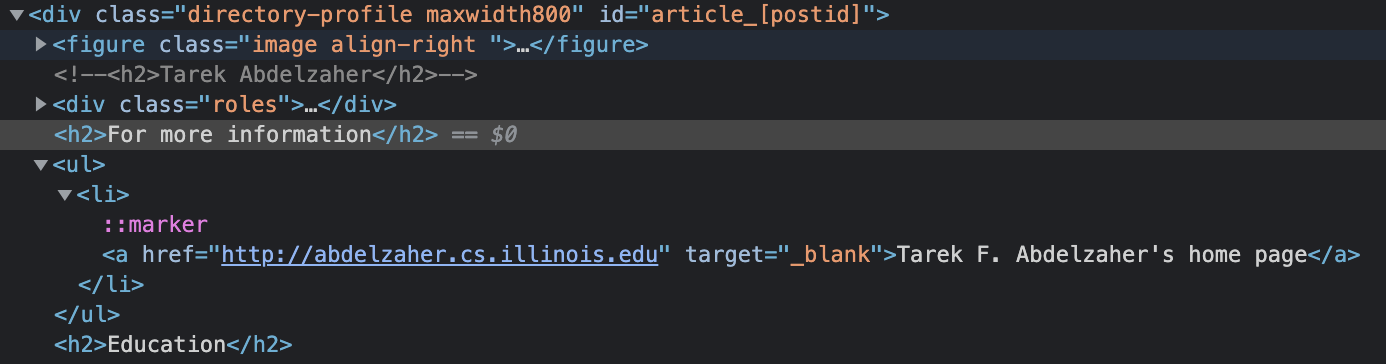

In [28]:
def scrape_faculty_page(fac_url,driver):
    soup = get_js_soup(fac_url,driver)
    homepage_found = False
    bio_url = ''
    bio = ''
    profile_sec = soup.find('div',class_='directory-profile') #####modification here and the above picture is new code
    if profile_sec is not None:
        all_headers = profile_sec.find_all('h2')
        faculty_last_name = all_headers[0].get_text().lower().split()[-1] #find faculty last name
        faculty_first_name = all_headers[0].get_text().lower().split()[0]
        homepage_txts = ['site','page',faculty_last_name,faculty_first_name]
        exceptions = ['course ','research','group','cs','mirror','google scholar']
        #find the homepage url and extract all text from it
        for hdr in all_headers:  #first find the required header
            if hdr.text.lower() == 'for more information':
                next_tag = hdr.find_next('li')
                #find <li> which has homepage url
                while next_tag is not None: 
                    cand = next_tag.find('a')
                    next_tag = next_tag.next_sibling  #sibling means element present at the same level
                    try:
                        cand['href']
                    except:
                        continue
                    cand_text = cand.string

                    if cand_text is not None and (any(hp_txt in cand_text.lower() for hp_txt in homepage_txts) and 
                        not any(e in cand_text.lower() for e in exceptions)): #compare text to predefined patterns
                        bio_url = cand['href'] 
                        homepage_found = True
                        #check if homepage url is valid
                        if not(is_valid_homepage(bio_url,fac_url)):
                            homepage_found = False
                        else:
                            try:
                                bio_soup = remove_script(get_js_soup(bio_url,driver)) 
                            except:
                                print ('Could not access {}'.format(bio_url))
                                homepage_found = False
                        break 
                if homepage_found:
                    #get all the text from homepage(bio)
                    bio = process_bio(bio_soup.get_text(separator=' ')) 


        if not homepage_found:
            bio_url = fac_url #treat faculty profile page as homepage
            bio = process_bio(profile_sec.get_text(separator=' '))

    return bio_url,bio

It takes a few minutes to scrape all the urls

In [29]:
#Scrape homepages of all urls
bio_urls, bios = [],[]
tot_urls = len(faculty_links)
for i,link in enumerate(faculty_links):
    print ('-'*20,'Scraping faculty url {}/{}'.format(i+1,tot_urls),'-'*20)
    bio_url,bio = scrape_faculty_page(link,driver)
    if bio.strip()!= '' and bio_url.strip()!='':
        bio_urls.append(bio_url.strip())
        bios.append(bio)
driver.close()

-------------------- Scraping faculty url 1/192 --------------------
-------------------- Scraping faculty url 2/192 --------------------
-------------------- Scraping faculty url 3/192 --------------------
-------------------- Scraping faculty url 4/192 --------------------
-------------------- Scraping faculty url 5/192 --------------------
-------------------- Scraping faculty url 6/192 --------------------
-------------------- Scraping faculty url 7/192 --------------------
-------------------- Scraping faculty url 8/192 --------------------
-------------------- Scraping faculty url 9/192 --------------------
-------------------- Scraping faculty url 10/192 --------------------
-------------------- Scraping faculty url 11/192 --------------------
-------------------- Scraping faculty url 12/192 --------------------
-------------------- Scraping faculty url 13/192 --------------------
-------------------- Scraping faculty url 14/192 --------------------
-------------------- Scraping

IndexError: list index out of range

Finally, write urls and extracted bio to txt files

In [ ]:
def write_lst(lst,file_):
    with open(file_,'w') as f:
        for l in lst:
            f.write(l)
            f.write('\n')

In [ ]:
bio_urls_file = 'bio_urls.txt'
bios_file = 'bios.txt'
write_lst(bio_urls,bio_urls_file)
write_lst(bios,bios_file)